In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import math as m
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics
import gzip
import datetime
import pickle
import pandas as pd
import os

gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

# Part 1

## Reading The Data from Memory

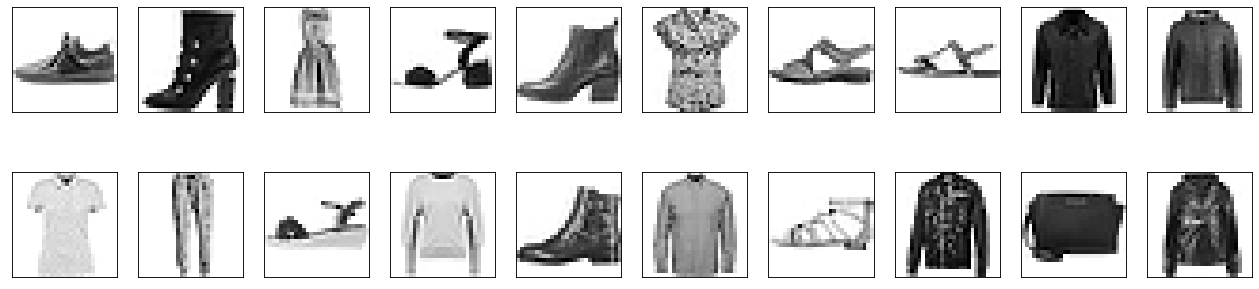

In [314]:
def read_bytes(address):
    
    f = gzip.open(address, 'r')
    buffer = f.read(-1)
    return buffer

def load_data():
    
    X_train_bytes = tf.constant(read_bytes('Data/train-images-idx3-ubyte.gz')[16:])
    X_train = tf.io.decode_raw(X_train_bytes, tf.uint8)
    X_train = tf.reshape(X_train, [-1, 28, 28,1])

    y_train_bytes = tf.constant(read_bytes('Data/train-labels-idx1-ubyte.gz')[8:])
    y_train = tf.io.decode_raw(y_train_bytes, tf.uint8)
    y_train = tf.reshape(y_train, [-1])

    X_test_bytes = tf.constant(read_bytes('Data/t10k-images-idx3-ubyte.gz')[16:])
    X_test = tf.io.decode_raw(X_test_bytes, tf.uint8)
    X_test = tf.reshape(X_test, [-1, 28, 28,1])

    y_test_bytes = tf.constant(read_bytes('Data/t10k-labels-idx1-ubyte.gz')[8:])
    y_test = tf.io.decode_raw(y_test_bytes, tf.uint8)
    y_test = tf.reshape(y_test, [-1])

    return tf.cast(X_train, dtype = tf.float32), tf.cast(X_test, dtype = tf.float32), tf.cast(y_train,dtype = tf.float32), tf.cast(y_test, dtype = tf.float32)


@tf.function
def one_hot_encoder(label):
    label = tf.cast(label, dtype = tf.int32)
    label = tf.one_hot(label, depth = 10)
    return label


@tf.function
def max_normalize(X):
    X= tf.cast(X, dtype = tf.float32)
    X = tf.divide(X, 255.0)
    return X


X_train, X_test, y_train, y_test = load_data()


X_train = max_normalize(X_train)
X_test = max_normalize(X_test)
y_train = one_hot_encoder(y_train)
y_test = one_hot_encoder(y_test)



def show_real_images(X):
    _ , axes = plt.subplots(2,10,figsize=(20,5),facecolor='white', dpi = 80)
    p = 0
    arr = np.arange(X.shape[0])
    loc = np.random.choice(arr,size = 20, replace=False)
    for i in range(2):
      for j in range(10):
        axes[i,j].imshow(X[loc[p]], cmap="binary", interpolation="nearest")
        # axes[i,j].set_title("{} ({}) ".format(y[loc[p]], title) ,fontsize = 12)
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])   
        p +=1
    plt.plot()


show_real_images(np.reshape(X_train,[-1,28,28] ))




In [255]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]


## Transformation, Augumentation, etc Functions

In [315]:

def visualize(original, augmented, str_):

    fig, axes = plt.subplots(1,2, figsize = (8, 4),  facecolor='White')
    
    axes[0].set_title('Original image')
    axes[0].imshow(original[:, :,0])

    axes[1].set_title('Augmented image ' + str_)
    axes[1].imshow(augmented[:, :,0])
    plt.plot()


# def bright_image(image, label, seed):
#     x = image
#     x = x/255.0

#     bright_image = tf.image.random_brightness( x, max_delta=100, seed= 3)
#     # visualize(x, bright_image, "Bright")
#     return bright_image, label


@tf.function
def flip_left_right (image, label, seed):
    flip_left_right = tf.image.flip_left_right(image)
    # visualize(x, flip_left_right, 'flip_left_right')
    return flip_left_right , label


@tf.function
def rot_1(image, label, seed):
    rot = tf.image.rot90( image, k=1)
    # visualize(x, rot2 , 'rot2 ')
    return rot, label

@tf.function
def gamma(image, label, seed):
    gamma = tf.image.adjust_gamma(image, 0.3)
    # visualize(x, gamma , 'gamma ')
    return gamma, label    

# @tf.function   
# def mean(image, label, seed):
#     x = image
#     x = x/255.0
    
#     mean = tfa.image.mean_filter2d(x, filter_shape=(1,1))
#     # visualize(x, mean , 'mean ')
#     return mean, label

@tf.function
def rotate_random(image, label, seed = 5):

    pi = tf.cast(m.pi, dtype = tf.float32)
    seed = tf.math.floormod(tf.cast(seed, dtype = tf.float32),9)


    rotate_random = tfa.image.rotate(image, 2*pi/(seed + 1))
    # visualize(x, rotate_random , 'rotate_random')
    return rotate_random, label

@tf.function
def rotate_random_gaussian(image, label, seed = 5):

    pi = tf.cast(m.pi, dtype = tf.float32)
    seed = tf.math.floormod(tf.cast(seed, dtype = tf.float32),9)

    out = tfa.image.gaussian_filter2d(
        image = image,
        filter_shape = (3, 3),
        sigma = 1.0,
        padding = 'REFLECT',
        constant_values = 0,
        name = None
    )
    rotate_random = tfa.image.rotate(out, 2*pi/(seed + 1))
    # visualize(x, rotate_random , 'rotate_random')
    return rotate_random, label

@tf.function
def rot_2(image, label, seed = 0):

    rot = tf.image.rot90( image, k=3)
    # visualize(x, rot2 , 'rot2 ')
    return rot, label

@tf.function
def flip_up_down(image, label, seed):

    flip_up_down = tf.image.flip_up_down(image)
    # visualize(x, flip_left_right, 'flip_left_right')
    return flip_up_down , label

@tf.function
def crop_and_resize(image, label, seed):

    # Extracts crops from the input image tensor and resizes 
    # them using bilinear sampling or nearest neighbor sampling 
    # (possibly with aspect ratio change) to a common output size specified
    # The cropped boxes are all resized (with bilinear or nearest neighbor interpolation) 

  
    image = tf.reshape(image, [1,28,28,1])
    boxes = [[0.125, 0.125, 0.75,0.75]]
    box_indices = tf.constant([0], dtype=tf.int32)
    output = tf.image.crop_and_resize(image, boxes, box_indices, (28, 28), method= "bilinear")
    # output.shape  #=> (-1, 28, 28, 1)`
    output = tf.reshape(output, [28,28,1])
    return output, label

@tf.function
def gaussian_blur(image, label, seed):

    # Perform Gaussian blur on image
    out = tfa.image.gaussian_filter2d(
        image = image,
        filter_shape = (3, 3),
        sigma = 1.0,
        padding = 'REFLECT',
        constant_values = 0,
        name = None
    )
    return out, label

@tf.function
def median_blur(image, label, seed):


    out =tfa.image.median_filter2d(
    image,
    filter_shape= (3, 3),
    padding ='REFLECT',
    constant_values= 0,
    name = None
) 
    return out, label

def plot_10_samples(dataset):
    i = 0
    transformed_sample = []
    for element in dataset:    
        if(i <10):
            transformed_sample.append((tf.reshape(element[0], [28,28]), element[1]))
            i = i + 1
        else:
            break

    _ , axes = plt.subplots(1,10,figsize=(20,10),facecolor='white', dpi = 80)
    p = 0
    for i in range(1):
        for j in range(10):
            axes[j].imshow(transformed_sample[p][0], cmap="binary", interpolation="nearest")
            axes[j].set_xticks([])
            axes[j].set_yticks([])   
            p +=1
        plt.plot()


def augument(dataset):
    # d= dataset.map(bright_image, num_parallel_calls=BATCH_SIZE)
    # plot_10_samples(d)
    
    d= dataset.map(flip_left_right , num_parallel_calls=BATCH_SIZE)
    plot_10_samples(d)

    d4= dataset.map(rot_1, num_parallel_calls=BATCH_SIZE)
    plot_10_samples(d4)
    d= d.concatenate(d4)

    d5= dataset.map(gamma, num_parallel_calls=BATCH_SIZE)
    plot_10_samples(d5)
    d= d.concatenate(d5)

    d6= dataset.map(rotate_random_gaussian, num_parallel_calls=BATCH_SIZE)
    plot_10_samples(d6)
    d= d.concatenate(d6)

    
    d7= dataset.map(rotate_random, num_parallel_calls=BATCH_SIZE)
    plot_10_samples(d7)
    d= d.concatenate(d7)

    d8= dataset.map(rot_2, num_parallel_calls=BATCH_SIZE)
    plot_10_samples(d8)
    d= d.concatenate(d8)

    d9= dataset.map(flip_up_down, num_parallel_calls=BATCH_SIZE)
    plot_10_samples(d9)
    d= d.concatenate(d9)

    d10= dataset.map(crop_and_resize, num_parallel_calls=BATCH_SIZE)
    plot_10_samples(d10)
    d= d.concatenate(d10)

    d11= dataset.map(gaussian_blur, num_parallel_calls=BATCH_SIZE)
    plot_10_samples(d11)
    d= d.concatenate(d11)

    d12= dataset.map(median_blur, num_parallel_calls=BATCH_SIZE)
    plot_10_samples(d12)
    d= d.concatenate(d12)
    return d

#change

## Loading and Preprocessing Data with tf.data pipeline

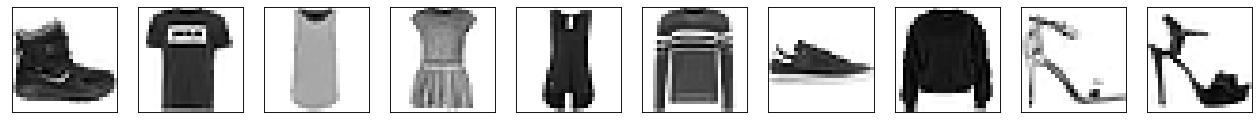

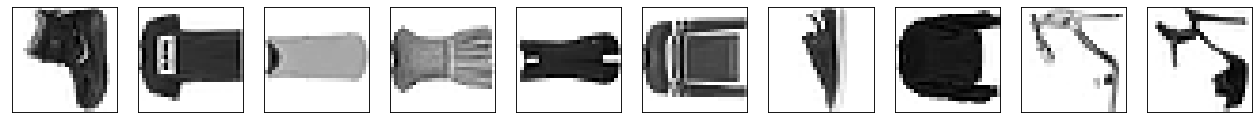

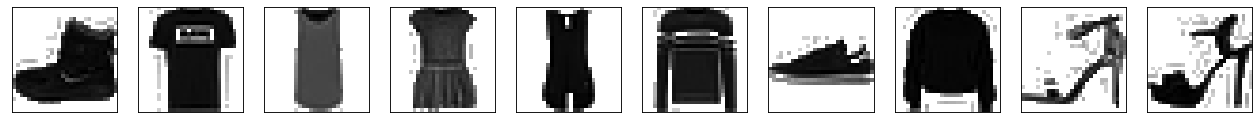

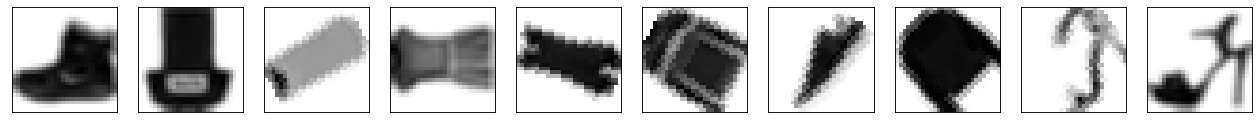

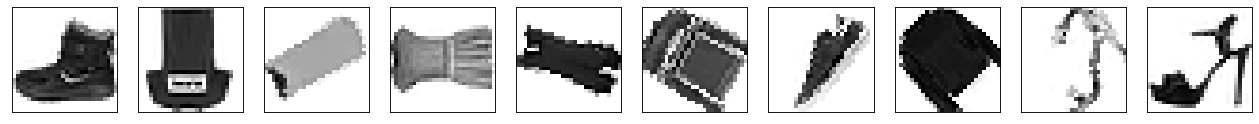

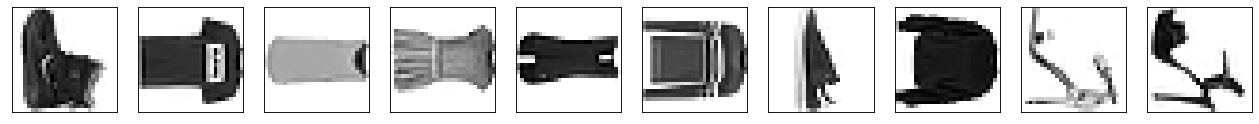

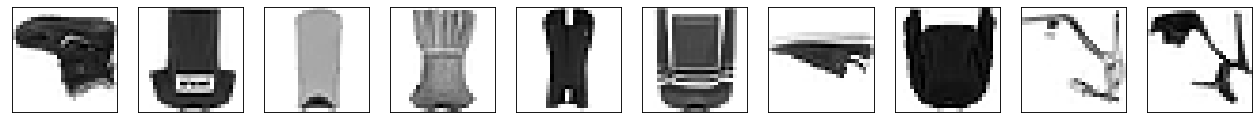

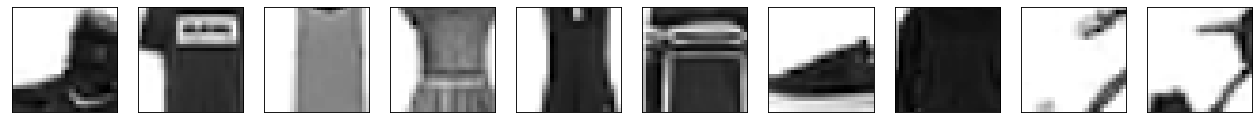

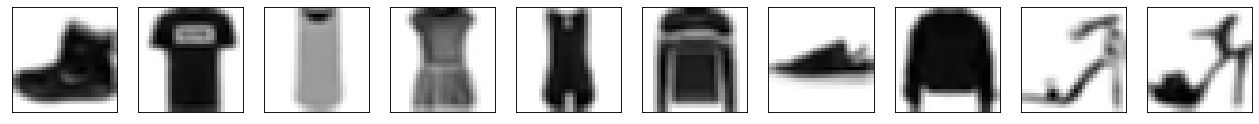

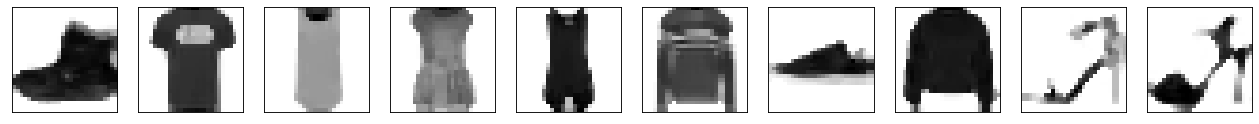

In [316]:
BATCH_SIZE = 32
SHUFFLE_SEED = 9


X_train_dataset = tf.data.Dataset.from_tensor_slices(X_train[0:50000])
y_train_dataset = tf.data.Dataset.from_tensor_slices(y_train[0:50000])

X_val_dataset = tf.data.Dataset.from_tensor_slices(X_train[50000:60000])
y_val_dataset = tf.data.Dataset.from_tensor_slices(y_train[50000:60000])

X_test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
y_test_dataset = tf.data.Dataset.from_tensor_slices(y_test)


counter = tf.data.experimental.Counter()

train_dataset = tf.data.Dataset.zip(
    (X_train_dataset, y_train_dataset, counter)).apply(augument).shuffle(600000)


val_dataset = tf.data.Dataset.zip(
    (X_val_dataset, y_val_dataset))


test_dataset = tf.data.Dataset.zip(
    (X_test_dataset, y_test_dataset))



## Transformed, Augumented and Rotated Images

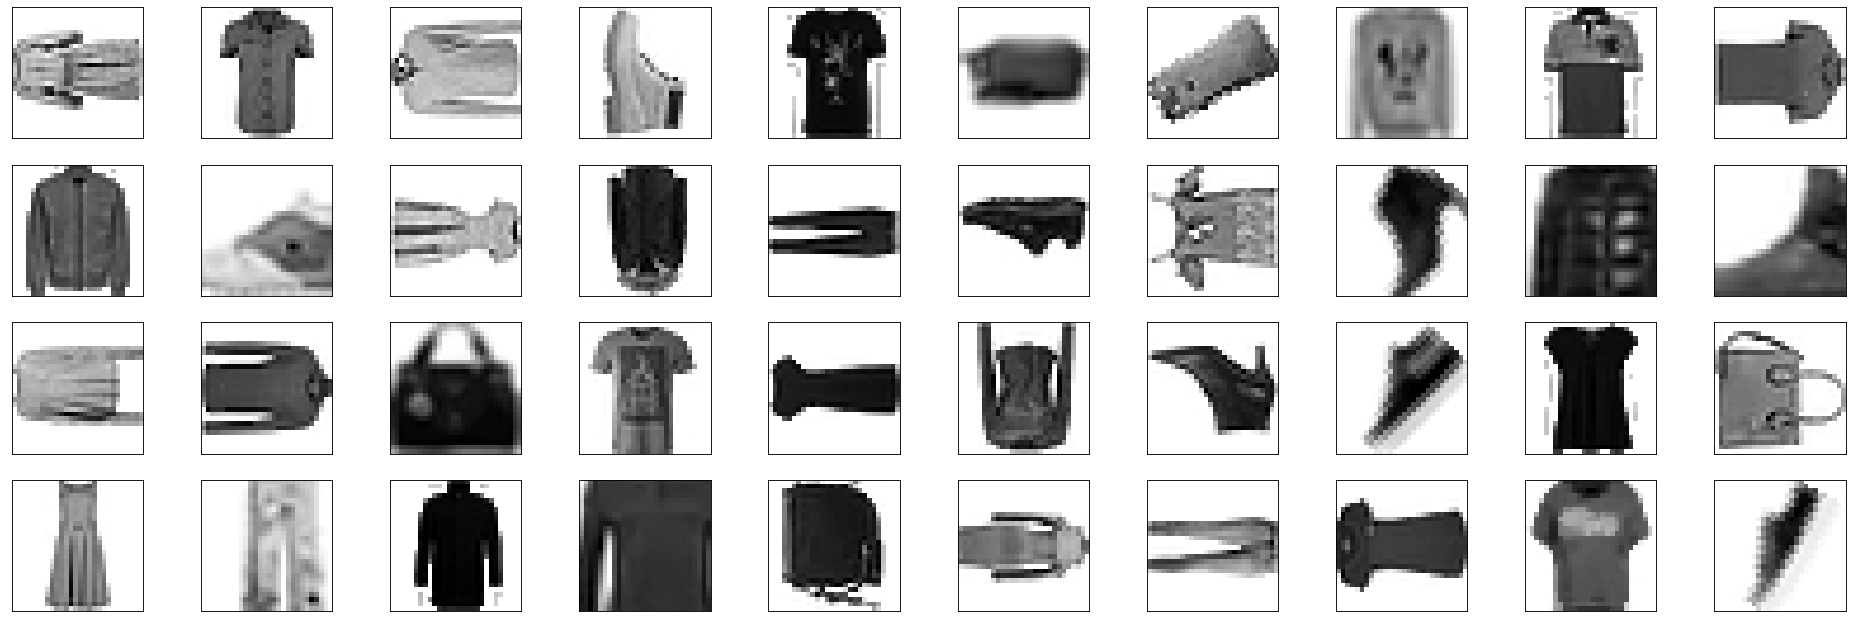

In [317]:
def plot_40_samples(dataset):
    i = 0
    transformed_sample = []
    for element in dataset:    
        if(i <40):
            transformed_sample.append(tf.reshape(element[0], [28,28]))
            i = i + 1
        else:
            break

    _ , axes = plt.subplots(4,10,figsize=(30,10),facecolor='white', dpi = 80)
    p = 0
    for i in range(4):
        for j in range(10):
            axes[i,j].imshow(transformed_sample[p], cmap="binary", interpolation="nearest")
            axes[i,j].set_xticks([])
            axes[i,j].set_yticks([])   
            p +=1
        plt.plot()

plot_40_samples(train_dataset)

# Part 2

## CNN Network from scrath with TensorFlow without Keras

In [262]:
class CNN_Model():
    def __init__(self,leaky_relu_alpha = 0.2,dropout_rate = 0.0, **kwargs):
     
        self.leaky_relu_alpha = leaky_relu_alpha 
        self.dropout_rate = dropout_rate
        self.padding = "VALID"
        self.initializer =  tf.initializers.GlorotUniform(seed =23)

        self.n_k = 16
        self.K1 = tf.Variable( self.initializer( [ 3 , 3 , 1 , 64 ] ) , name="K1" , dtype=tf.float32 )
        self.K2 = tf.Variable( self.initializer([ 3 , 3 , 64 , 128 ] ) , name="K2" , dtype=tf.float32 )
        self.K3 = tf.Variable( self.initializer( [ 3 , 3 , 128 , 128 ]) , name="K3" , dtype=tf.float32 )
        self.K4 = tf.Variable( self.initializer( [ 3 , 3 , 128 , 256 ] ) , name="K4" , dtype=tf.float32 )
        self.K5 = tf.Variable( self.initializer( [ 3 , 3 , 256 , 256 ]) , name="K5" , dtype=tf.float32 )
      

        self.W6 = tf.Variable( self.initializer( [  256 , 128 ] ) , name="K6" , dtype=tf.float32 )
        self.W7 = tf.Variable( self.initializer( [  128 , 64 ] ) , name="K6" , dtype=tf.float32 )
        self.W8 = tf.Variable( self.initializer( [  64 , 10 ] ) , name="K6" , dtype=tf.float32 )


        self.B1 = tf.Variable(tf.zeros([26, 26, 64]))
        self.B2 = tf.Variable(tf.zeros([24, 24, 128]))
        self.B3 = tf.Variable(tf.zeros([10, 10, 128]))
        self.B4 = tf.Variable(tf.zeros([8, 8, 256]))
        self.B5 = tf.Variable(tf.zeros([2, 2, 256]))
        self.B6 = tf.Variable(tf.zeros([128]))
        self.B7 = tf.Variable(tf.zeros([64]))
        self.B8 = tf.Variable(tf.zeros([10])) 

    @tf.function
    def call(self,x):

        c1 = tf.nn.conv2d( x , self.K1 , strides=[ 1 , 1 , 1 , 1 ] , padding='VALID' ) 
        c1 = c1 + self.B1
        c1 = tf.nn.leaky_relu( c1 , alpha=self.leaky_relu_alpha )  

        c1 = tf.nn.conv2d( c1 , self.K2 , strides=[ 1 , 1 , 1 , 1 ] , padding='VALID' ) 
        c1 = c1 + self.B2
        c1 = tf.nn.leaky_relu( c1 , alpha=self.leaky_relu_alpha )
        p1 = tf.nn.max_pool2d( c1 , ksize=[ 1 , 2 , 2 , 1 ] , padding='VALID' , strides=[ 1 , 2 , 2 , 1 ] ) 


        c2 = tf.nn.conv2d( p1 , self.K3 , strides=[ 1 , 1 , 1 , 1 ] , padding='VALID' )
        c2 = c2 + self.B3
        c2 = tf.nn.leaky_relu( c2 , alpha=self.leaky_relu_alpha )
    
        c2 = tf.nn.conv2d( c2 , self.K4, strides=[ 1 , 1 , 1 , 1 ] , padding='VALID' )
        c2 = c2 + self.B4
        c2 = tf.nn.leaky_relu( c2 , alpha=self.leaky_relu_alpha ) 
        p2 = tf.nn.max_pool2d( c2 , ksize=[ 1 , 2 ,2 , 1 ] , padding='VALID' , strides=[ 1 , 2 , 2 , 1 ] )
        
        c3 = tf.nn.conv2d( p2 , self.K5, strides=[ 1 , 1 , 1 , 1 ] , padding='VALID' )
        c3 = c3 + self.B5
        c3 = tf.nn.leaky_relu( c3 , alpha=self.leaky_relu_alpha ) 
        p3 = tf.nn.max_pool2d( c3 , ksize=[ 1 , 2 ,2 , 1 ] , padding='VALID' , strides=[ 1 , 2 , 2 , 1 ] )

        flatten = tf.reshape( p3 , shape=( tf.shape( p3 )[0] , -1 ))

        d1 = tf.matmul( flatten , self.W6 )
        d1 = d1 + self.B6 
        d1 = tf.nn.leaky_relu(d1  , alpha=self.leaky_relu_alpha )
        d1 = tf.nn.dropout( d1 , rate= self.dropout_rate )
             
        d2 = tf.matmul( d1 , self.W7 )
        d2 = d2 + self.B7 
        d2 = tf.nn.leaky_relu(d2  , alpha=self.leaky_relu_alpha )
        d2 = tf.nn.dropout( d2 , rate= self.dropout_rate )

        d3 = tf.matmul( d2 , self.W8 )

        return tf.nn.softmax( d3 )

    @tf.function    
    def loss(self, pred , target ):
        return tf.reduce_mean(tf.losses.categorical_crossentropy( target , pred ))

    @tf.function
    def predict(self, x):
        p = self.call(x)
        return tf.argmax(p , axis = 1)



In [282]:
val_losses = []
model = CNN_Model()


In [283]:
@tf.function
def train_step(model, X, y, lr):
    with tf.GradientTape() as tape:
        out = model.call(X)
        l = model.loss( out, y)

    W = [model.K1, model.K2,model.K3, model.K4, model.K5, model.W6, model.W7, model.W8,
        #  model.B1, model.B2,model.B3, model.B4, model.B5, model.B6, model.B7, model.B8   
             ]
    dl_dW = tape.gradient(l ,W)

    for dl_dw, w in zip(dl_dW,W):
        t = tf.multiply(-lr,dl_dw)
        w.assign(tf.math.add(w, t))

    return l

#Pickling
def save_checkpoint():
    stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    directory = "{}".format(stamp)
    parent = '\Assignment_5_Quantiphi\checkpoint'
    path = os.path.join(parent, directory)

    os.mkdir(path)
    
    with open(path + '\model_pkl', 'wb') as files:
        pickle.dump(model, files)

    with open(path + "\Val_loss.txt", "wb") as fp:
        pickle.dump(val_losses, fp)

 

In [405]:
BATCH_SIZE = 128
train_set = train_dataset.batch(BATCH_SIZE).prefetch(-1)
val_set = val_dataset.batch(BATCH_SIZE).prefetch(-1)
test_set = test_dataset.batch(BATCH_SIZE).prefetch(-1)

## Model Training


In [ ]:
num_epochs = 50

model.dropout_rate = 0.0

#Pickling
def save_checkpoint():
    stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    directory = "{}".format(stamp)
    parent = '\Assignment_5_Quantiphi\checkpoint'
    path = os.path.join(parent, directory)

    os.mkdir(path)
    
    with open(path + '\model_pkl', 'wb') as files:
        pickle.dump(model, files)

    with open(path + "\Val_loss.txt", "wb") as fp:
        pickle.dump(val_losses, fp)



for e in range(0, num_epochs ):
        
    lr = tf.cast(tf.math.pow(0.01, tf.add(1, tf.divide(e, 10))), dtype =tf.float32)
    # lr = 0.01
    print("{}/{} --  LR: {} ".format(e,num_epochs,lr))

    for X_batch, y_batch in train_set:    
            loss = train_step(model,X_batch,y_batch, lr )
            print( "Batch Training Loss : ", loss.numpy())

    val_loss = 0
    for X, y in val_set:
        out = model.call(X)
        l = model.loss( out, y)
        print( "Batch Training Loss : ", loss.numpy())
        val_loss += l
            
    val_loss = val_loss/10000

    val_losses.append(val_loss)

    print("{}/{} --  LR: {}  Val loss: {} ".format(e,num_epochs,lr, np.mean(val_loss)))

    if(e %3 == 0):
        save_checkpoint()


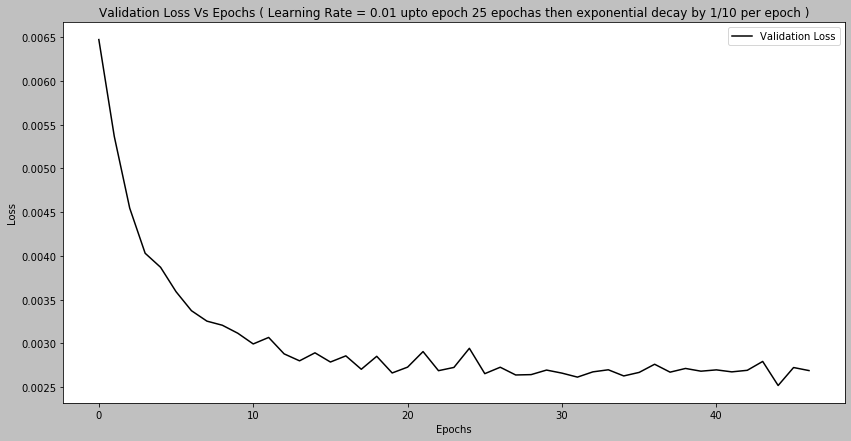

In [293]:
_, ax = plt.subplots(1,1,figsize = (14,7), facecolor='silver')
ax.set_facecolor('white')
ax.plot(val_losses, "black", label  = "Validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Validation Loss Vs Epochs ( Learning Rate = 0.01 upto epoch 25 epochas then exponential decay by 1/10 per epoch )")
ax.legend()
   

## Saving The Model With Lowest Validation Loss

In [294]:
with open('model_pkl', 'wb') as files:
    pickle.dump(model, files)

with open("Val_loss.txt", "wb") as fp:
    pickle.dump(val_losses, fp)

## Use of Saved Model For Inference

In [295]:
with open('model_pkl', 'rb') as f:
    loaded_model = pickle.load(f)


predictions = []
actuals = []

BATCH_SIZE = 128


for X, y in test_set:

    actual = tf.argmax(y , axis = 1).numpy()
    actuals.append(actual)

    prediction = model.predict(X).numpy()
    predictions.append(prediction)

actuals = [item for sublist in actuals for item in sublist]
predictions = [item for sublist in predictions for item in sublist]
accuracy = accuracy_score(actuals, predictions)

print("The accuracy of the model is {}".format(accuracy))

The accuracy of the model is 0.9004


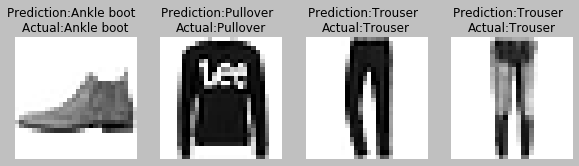

In [296]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3),  facecolor='silver')
for ax, image, prediction, actual in zip(axes, X_test.numpy()[0:100], predictions[0:100], actuals[0:100]):
    ax.set_axis_off()
    image = image.reshape(28, 28)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Prediction:{class_names [prediction]}  \nActual:{class_names [actual]}')


In [297]:
print(f"Classification report for classifier:\n"
      f"{metrics.classification_report(actuals, predictions)}\n")

Classification report for classifier:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1000
           1       0.98      0.98      0.98      1000
           2       0.85      0.87      0.86      1000
           3       0.88      0.91      0.89      1000
           4       0.88      0.79      0.83      1000
           5       0.97      0.97      0.97      1000
           6       0.73      0.75      0.74      1000
           7       0.93      0.98      0.96      1000
           8       0.95      0.95      0.95      1000
           9       0.98      0.94      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000




0 - T-shirt/top
1 - Trouser
2 - Pullover
3 - Dress
4 - Coat
5 - Sandal
6 - Shirt
7 - Sneaker
8 - Bag
9 - Ankle boot


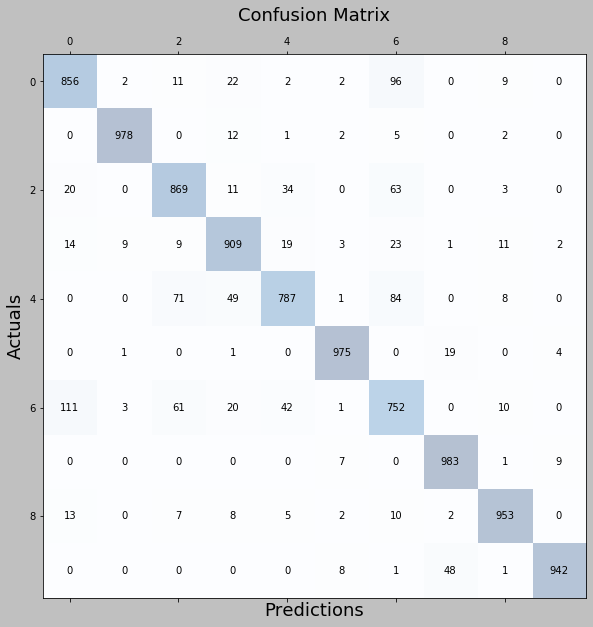

In [298]:
for i, name in enumerate(class_names):
    print("{} - {}".format(i, name))


conf_matrix = confusion_matrix(actuals, predictions)

fig, ax = plt.subplots(figsize=(10, 10),  facecolor='silver')
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()